In [1]:
import pydicom
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
root_data_dir = '/home/r079a/Desktop/de-identification/dataset'

targetdir = Path(root_data_dir, 'images/manifest-1617826555824/Pseudo-PHI-DICOM-Data/292821506/07-13-2013-NA-XR CHEST AP PORTABLE for Douglas Davidson-46198/1001.000000-NA-37718')

In [3]:
print(targetdir)

/home/r079a/Desktop/de-identification/dataset/images/manifest-1617826555824/Pseudo-PHI-DICOM-Data/292821506/07-13-2013-NA-XR CHEST AP PORTABLE for Douglas Davidson-46198/1001.000000-NA-37718


In [4]:
from os import listdir
from os.path import isfile, join
from pathlib import Path

In [5]:
onlyfiles = [f for f in listdir(targetdir) if isfile(join(targetdir, f))]
print(onlyfiles)

['1-1.dcm']


In [6]:
sampledcm = Path(targetdir,onlyfiles[0])

In [7]:
ds = pydicom.dcmread(sampledcm)

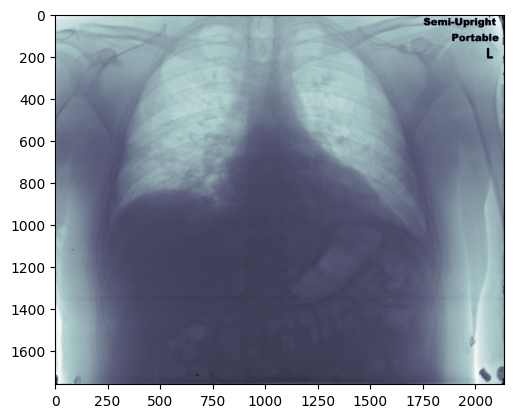

In [8]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [9]:
import pandas as pd

In [10]:
metadatafile = Path(root_data_dir, 'images/manifest-1617826555824/metadata.csv')

samplemetadata = pd.read_csv(metadatafile)

In [11]:
samplemetadata.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,2.25.22373700284337223907674770690654453238,Pseudo-PHI-DICOM-Data,NO,https://doi.org/10.7937/s17zr072,292821506,2.25.106461954783291641048254423668956446198,XR CHEST AP PORTABLE for Douglas Davidson,07-13-2013,NaN,FUJIFILM Corporation,CR,Computed Radiography Image Storage,1.2.840.10008.5.1.4.1.1.1,1,7.53 MB,./Pseudo-PHI-DICOM-Data/292821506/07-13-2013-N...,2024-06-03T18:20:37.027
1,2.25.159938781348401988370074200042204937718,Pseudo-PHI-DICOM-Data,NO,https://doi.org/10.7937/s17zr072,292821506,2.25.106461954783291641048254423668956446198,XR CHEST AP PORTABLE for Douglas Davidson,07-13-2013,NaN,FUJIFILM Corporation,CR,Computed Radiography Image Storage,1.2.840.10008.5.1.4.1.1.1,1,7.53 MB,./Pseudo-PHI-DICOM-Data/292821506/07-13-2013-N...,2024-06-03T18:20:38.616
2,2.25.16889725737787757262937018243711876598,Pseudo-PHI-DICOM-Data,NO,https://doi.org/10.7937/s17zr072,3642991663,2.25.274128889631512605961383205193865870838,PET-CT STUDY for Shelly Wallace,07-05-1961,PET-CT SERIES,GE MEDICAL SYSTEMS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,174,6.63 MB,./Pseudo-PHI-DICOM-Data/3642991663/07-05-1961-...,2024-06-03T18:20:47.041
3,2.25.45367868844278747809947145409050295798,Pseudo-PHI-DICOM-Data,NO,https://doi.org/10.7937/s17zr072,3209648408,2.25.186760260011452398476108131496539831798,CT UROGRAM,09-23-1999,PARENCHYMAL PHASE Sep1999,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,152,80.10 MB,./Pseudo-PHI-DICOM-Data/3209648408/09-23-1999-...,2024-06-03T18:20:55.924
4,2.25.30562807935945476104184698489410272758,Pseudo-PHI-DICOM-Data,NO,https://doi.org/10.7937/s17zr072,4025360156,2.25.229096719175496207600372892792583208438,CT Urogram w 3D,10-25-1993,NONE,FUJIFILM Corporation,CR,Computed Radiography Image Storage,1.2.840.10008.5.1.4.1.1.1,1,6.21 MB,./Pseudo-PHI-DICOM-Data/4025360156/10-25-1993-...,2024-06-03T18:20:57.728


### Map between Eval and Deidentified UIDs

In [12]:
import csv

uidmapfile = Path(root_data_dir, 'Pseudo-PHI-DICOM-Dataset-uid_crosswalk.csv')
eval_2_deid =  {}
deid_2_eval = {}

with open(uidmapfile, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    linecount = 0
    for row in spamreader:
        if linecount == 0:
            linecount += 1
            continue
        eval_2_deid[row[0]] = row[1]
        deid_2_eval[row[1]] = row[0]
        linecount += 1

In [13]:
def load_metadata(filename: str):
    return pd.read_csv(filename)

def load_dicoms_from_path(dicompath: str):
    alldicompaths = [f for f in listdir(dicompath) if isfile(join(dicompath, f))]
    alldicoms = []
    for dcm in alldicompaths:
        dcmpath = Path(dicompath, dcm)
        ds = pydicom.dcmread(dcmpath)
        alldicoms.append(ds)
    return alldicoms

In [14]:
def load_series_by_index(metadatafile: str, seriesidx: int):
    metadata = load_metadata(metadatafile)
    assert seriesidx < len(metadata), f"Patient index greater than available patient dicoms. Available patients {len(metadata)}"
    
    target_row = metadata.loc[seriesidx]
    targetdcmdir = Path(Path(metadatafile).parent, str(target_row['File Location']))
    alldicoms = load_dicoms_from_path(targetdcmdir)
    
    return alldicoms, target_row.to_dict()

def get_series_index_from_id(metadatafile: str, seriesid: str):
    metadata_df = load_metadata(metadatafile)
    indexes = metadata_df[metadata_df['Series UID'] == seriesid].index.tolist()
    if len(indexes) == 0:
        return -1
    else:
        return indexes[0]
    

def display_dicoms_grid(dicoms: list, rows: int = 2, cols: int = 3):
    fig = plt.figure(figsize=(10,10))
    
    for idx, ds in enumerate(dicoms):
        if idx >= rows*cols:
            break
        fig.add_subplot(rows, cols, idx+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

def display_dicom(ds):
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

### Explore Raw dicoms

In [15]:
TARGETSERIESIDX = 4

In [16]:
metadatafile = Path(root_data_dir, 'images/manifest-1617826555824/metadata.csv')

In [17]:
alldicoms, patientmetadata = load_series_by_index(metadatafile, seriesidx=TARGETSERIESIDX)

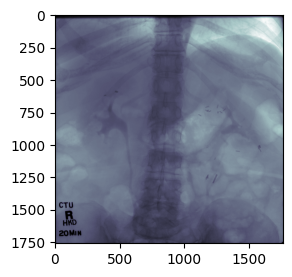

In [18]:
display_dicoms_grid(alldicoms)

In [19]:
sampleds = alldicoms[0]

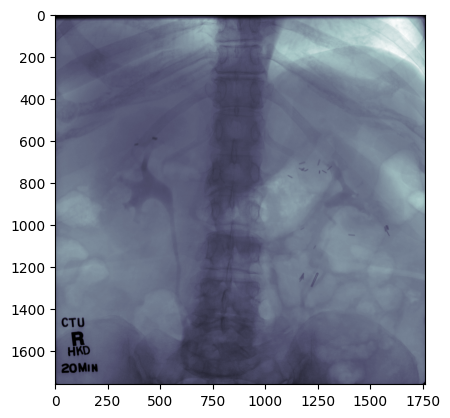

In [20]:
display_dicom(sampleds)

In [21]:
for element in sampleds:
    print(element)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.205802782939865713150381585183696076278
(0008, 0020) Study Date                          DA: '19931025'
(0008, 0021) Series Date                         DA: '19931025'
(0008, 0022) Acquisition Date                    DA: '19931025'
(0008, 0023) Content Date                        DA: '19931025'
(0008, 0030) Study Time                          TM: '155009.000'
(0008, 0031) Series Time                         TM: '155201'
(0008, 0032) Acquisition Time                    TM: '155201.104'
(0008, 0033) Content Time                        TM: '155320.898'
(0008, 0040) Data Set Type                       US: 0
(0008, 0041) Data Set Subtype                    LO: 

In [22]:
from pprint import pprint

pprint(patientmetadata)

{'3rd Party Analysis': 'NO',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Download Timestamp': '2024-06-03T18:20:57.728',
 'File Location': './Pseudo-PHI-DICOM-Data/4025360156/10-25-1993-NA-CT Urogram '
                  'w 3D-08438/1002.000000- NONE -72758',
 'File Size': '6.21 MB',
 'Manufacturer': 'FUJIFILM Corporation',
 'Modality': 'CR',
 'Number of Images': 1,
 'SOP Class Name': 'Computed Radiography Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.1',
 'Series Description': ' NONE ',
 'Series UID': '2.25.30562807935945476104184698489410272758',
 'Study Date': '10-25-1993',
 'Study Description': 'CT Urogram w 3D',
 'Study UID': '2.25.229096719175496207600372892792583208438',
 'Subject ID': 4025360156}


### Explore deidentified Dicoms

In [23]:
deidmetafile = Path(root_data_dir, 'images-2/manifest-1617826161202/metadata.csv')

In [24]:
deid_series = eval_2_deid[patientmetadata['Series UID']]
deid_idx = get_series_index_from_id(deidmetafile, deid_series)

deid_dicoms, deid_pateintmetadata = load_series_by_index(deidmetafile, seriesidx=deid_idx)

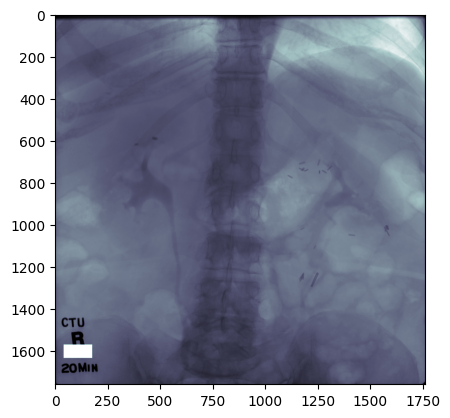

In [25]:
display_dicom(deid_dicoms[0])

In [26]:
for element in deid_dicoms[0]:
    print(element)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', '', '', '', '', '', '100000']
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.8700.9668.255528347075901908166105950632
(0008, 0020) Study Date                          DA: '19831008'
(0008, 0021) Series Date                         DA: '19831008'
(0008, 0022) Acquisition Date                    DA: '19831008'
(0008, 0023) Content Date                        DA: '19831008'
(0008, 0030) Study Time                          TM: '155009.000'
(0008, 0031) Series Time                         TM: '155201'
(0008, 0032) Acquisition Time                    TM: '155201.104'
(0008, 0033) Content Time                        TM: '155320.898'
(0008, 0040) Data Set Type                       US: 0
(0008, 0041) Data Set Subtype    

In [27]:
pprint(deid_pateintmetadata)

{'3rd Party Analysis': 'NO',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Download Timestamp': '2024-06-03T18:25:32.851',
 'File Location': './Pseudo-PHI-DICOM-Data/Pseudo-PHI-006/10-08-1983-NA-CT '
                  'Urogram w 3D-69168/1002.000000- NONE -18707',
 'File Size': '6.21 MB',
 'Manufacturer': 'FUJIFILM Corporation',
 'Modality': 'CR',
 'Number of Images': 1,
 'SOP Class Name': 'Computed Radiography Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.1',
 'Series Description': ' NONE ',
 'Series UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.230087604482545573335222218707',
 'Study Date': '10-08-1983',
 'Study Description': 'CT Urogram w 3D',
 'Study UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.162978858546451794618803269168',
 'Subject ID': 'Pseudo-PHI-006'}


In [28]:
import sys
 
# setting path
sys.path.append('../')

from utils.dataloaders import MIDIEvalDataLoader

In [29]:
loader = MIDIEvalDataLoader(
    rawimagespath=Path(root_data_dir, 'images/manifest-1617826555824'),
    deidimagespath=Path(root_data_dir, 'images-2/manifest-1617826161202'),
    uidsmappath=Path(root_data_dir, 'Pseudo-PHI-DICOM-Dataset-uid_crosswalk.csv'),
)

In [33]:
rawdcm, deiddcm = loader.get_raw_n_deid_patient(4)

{'Series UID': '2.25.30562807935945476104184698489410272758', 'Collection': 'Pseudo-PHI-DICOM-Data', '3rd Party Analysis': 'NO', 'Data Description URI': 'https://doi.org/10.7937/s17zr072', 'Subject ID': 4025360156, 'Study UID': '2.25.229096719175496207600372892792583208438', 'Study Description': 'CT Urogram w 3D', 'Study Date': '10-25-1993', 'Series Description': ' NONE ', 'Manufacturer': 'FUJIFILM Corporation', 'Modality': 'CR', 'SOP Class Name': 'Computed Radiography Image Storage', 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.1', 'Number of Images': 1, 'File Size': '6.21 MB', 'File Location': './Pseudo-PHI-DICOM-Data/4025360156/10-25-1993-NA-CT Urogram w 3D-08438/1002.000000- NONE -72758', 'Download Timestamp': '2024-06-03T18:20:57.728'}


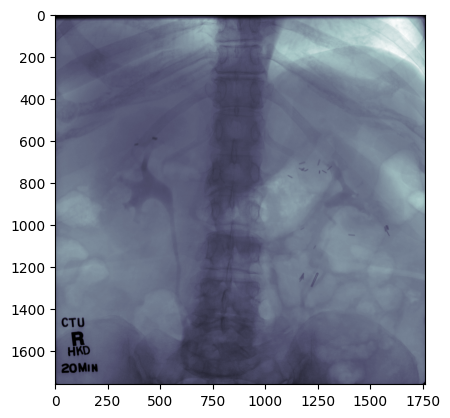

In [34]:
display_dicom(rawdcm[0])

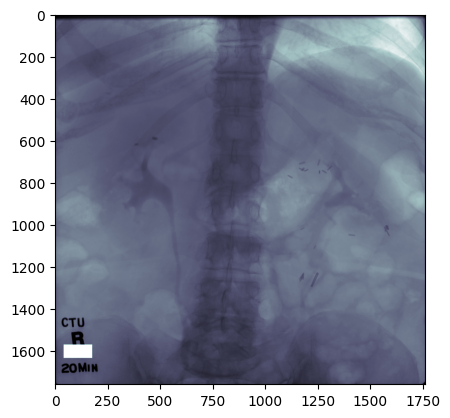

In [35]:
display_dicom(deiddcm[0])